In [1]:
!pip install scikit-optimize
!pip install -U pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 818.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210079 sha256=b518b428a19104e53757a52da11d88057864e4c11be218127db5e3b24ecefb64
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully bui

In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

11490434/11490434 [==============================] - 0s 0us/step
Iteration No: 1 started. Evaluating function at random point.
Epoch 1/2
422/422 [==============================] - 41s 94ms/step - loss: 0.0301 - accuracy: 0.6799 - val_loss: 0.0154 - val_accuracy: 0.7598
Epoch 2/2
422/422 [==============================] - 30s 70ms/step - loss: 0.0155 - accuracy: 0.7755 - val_loss: 0.0151 - val_accuracy: 0.7873
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 85.1691
Function value obtained: 0.0153
Current minimum: 0.0153
Iteration No: 2 started. Evaluating function at random point.
Epoch 1/2
422/422 [==============================] - 30s 70ms/step - loss: 0.0618 - accuracy: 0.1297 - val_loss: 0.0180 - val_accuracy: 0.1050
Epoch 2/2
422/422 [==============================] - 30s 71ms/step - loss: 0.0180 - accuracy: 0.1132 - val_loss: 0.0180 - val_accuracy: 0.1050
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 62.3541
Function value obtained: 0.0180

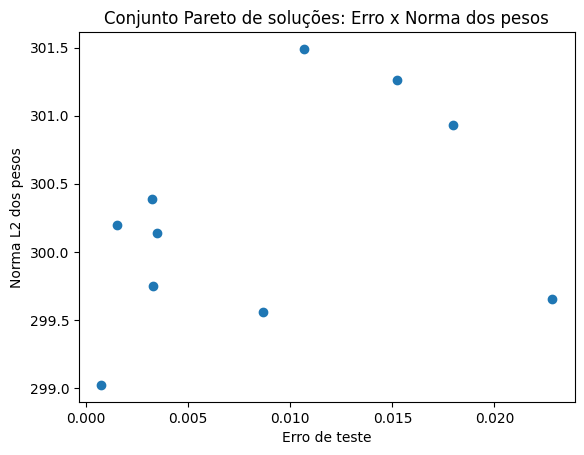

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from skopt import gp_minimize
import matplotlib.pyplot as plt

# Carregar os dados
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizar os dados
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

def build_cnn_model():
    # Criar o modelo da rede neural convolucional
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    return model

def chebyshev_loss(y_true, y_pred, model, lambda1, lambda2):
    # Função de perda Categorical Crossentropy
    ce_loss = keras.losses.CategoricalCrossentropy()(y_true, y_pred)

    # Função de regularização L2
    l2_loss = sum([tf.nn.l2_loss(layer.kernel) for layer in model.layers if 'Conv2D' in str(layer) or 'Dense' in str(layer)])

    # Combinar as funções de perda com os pesos de Chebyshev
    combined_loss = lambda1 * ce_loss + lambda2 * l2_loss

    return combined_loss

def objective(params):
    lambda1, lambda2 = params
    
    # Construir o modelo da CNN
    model = build_cnn_model()

    # Compilar o modelo com a função de perda personalizada e otimizador
    model.compile(loss=lambda y_true, y_pred: chebyshev_loss(y_true, y_pred, model, lambda1, lambda2), optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

    # Treinar o modelo
    model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1, verbose=1)

    # Avaliar o desempenho do modelo
    score = model.evaluate(x_test, y_test, verbose=0)
    
    return score[0]

space = [(0.0001, 0.01, "uniform"), (0.0001, 0.01, "uniform")]

result = gp_minimize(func=objective, dimensions=space, n_calls=10, random_state=42, verbose=1)

#Imprimir os melhores hiperparâmetros encontrados
best_lambda1, best_lambda2 = result.x
print(f"Melhores hiperparâmetros encontrados: lambda1 = {best_lambda1}, lambda2 = {best_lambda2}")

#Construir e treinar o melhor modelo
best_model = build_cnn_model()
best_model.compile(loss=lambda y_true, y_pred: chebyshev_loss(y_true, y_pred, best_model, best_lambda1, best_lambda2),
optimizer=keras.optimizers.Adam(), metrics=["accuracy"])
best_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1, verbose=1)

#Avaliar o melhor modelo
score = best_model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

#Função para calcular a norma L2 dos pesos do modelo
def calculate_l2_norm(model):
    l2_norm = sum([np.sum(np.square(layer.kernel.numpy())) for layer in model.layers if 'Conv2D' in str(layer) or 'Dense' in str(layer)])
    return l2_norm

#Preparar os dados para o gráfico do conjunto Pareto
pareto_error_data = [objective(params) for params in result.x_iters]
pareto_norm_data = [calculate_l2_norm(build_cnn_model()) for params in result.x_iters]

#Criar o gráfico do conjunto Pareto
plt.scatter(pareto_error_data, pareto_norm_data)
plt.xlabel("Erro de teste")
plt.ylabel("Norma L2 dos pesos")
plt.title("Conjunto Pareto de soluções: Erro x Norma dos pesos")
plt.show()



Este código realiza a otimização bayesiana usando a função `gp_minimize` da biblioteca `scikit-optimize`. A otimização bayesiana é aplicada para encontrar os melhores valores de lambda1 e lambda2 para a função de perda Chebyshev.

Após a otimização, o código constrói e treina o melhor modelo com os melhores hiperparâmetros encontrados. Em seguida, o código calcula o erro de teste e a norma L2 dos pesos para cada solução no conjunto Pareto, gerando um gráfico de dispersão para visualizar essas soluções.


Epoch 1/2
422/422 [==============================] - 41s 96ms/step - loss: 0.0303 - accuracy: 0.6519 - val_loss: 0.0152 - val_accuracy: 0.7822
Epoch 2/2
422/422 [==============================] - 30s 71ms/step - loss: 0.0155 - accuracy: 0.7733 - val_loss: 0.0149 - val_accuracy: 0.8157
Epoch 1/2
422/422 [==============================] - 31s 73ms/step - loss: 0.0622 - accuracy: 0.1284 - val_loss: 0.0180 - val_accuracy: 0.1050
Epoch 2/2
422/422 [==============================] - 32s 75ms/step - loss: 0.0180 - accuracy: 0.1132 - val_loss: 0.0180 - val_accuracy: 0.1050
Epoch 1/2
422/422 [==============================] - 31s 71ms/step - loss: 0.0171 - accuracy: 0.7068 - val_loss: 0.0085 - val_accuracy: 0.8202
Epoch 2/2
422/422 [==============================] - 31s 72ms/step - loss: 0.0088 - accuracy: 0.7834 - val_loss: 0.0085 - val_accuracy: 0.8128
Epoch 1/2
422/422 [==============================] - 31s 73ms/step - loss: 0.0358 - accuracy: 0.1259 - val_loss: 0.0107 - val_accuracy: 0.1050

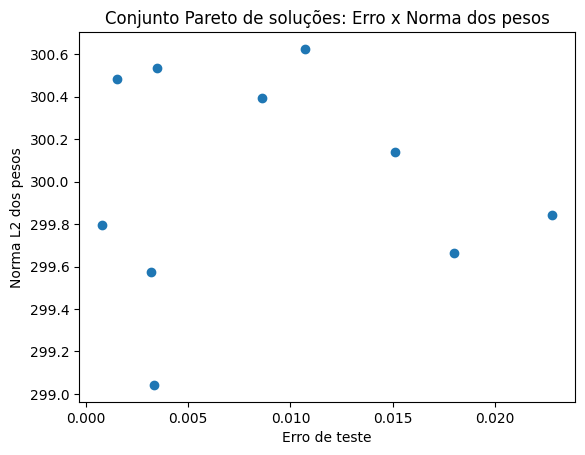

In [4]:
#Função para calcular a norma L2 dos pesos do modelo
def calculate_l2_norm(model):
    l2_norm = sum([np.sum(np.square(layer.kernel.numpy())) for layer in model.layers if 'Conv2D' in str(layer) or 'Dense' in str(layer)])
    return l2_norm

#Preparar os dados para o gráfico do conjunto Pareto
pareto_error_data = [objective(params) for params in result.x_iters]
pareto_norm_data = [calculate_l2_norm(build_cnn_model()) for params in result.x_iters]

#Criar o gráfico do conjunto Pareto
plt.scatter(pareto_error_data, pareto_norm_data)
plt.xlabel("Erro de teste")
plt.ylabel("Norma L2 dos pesos")
plt.title("Conjunto Pareto de soluções: Erro x Norma dos pesos")
plt.show()